# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [618]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
import numpy as np

### 1b. Load the data
Call the variable `cigData`. 

In [619]:
cigData = pd.read_csv('./CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [620]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [621]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [622]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


Check whether there are any null values. 

In [623]:
cigData[['Time','#CigSales']].isnull().any()

Time         False
#CigSales    False
dtype: bool

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [624]:
cigData.drop(columns='Unnamed: 0', inplace=True)

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [625]:
cigData.rename(columns={'Time': 'Month'}, inplace=True)

Call a head() to check this has worked. 

In [626]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [627]:
cigData['Month'] = pd.to_datetime(cigData['Month'])

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [628]:
y=cigData['#CigSales']

Check the type of our new variable. 

In [629]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [630]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

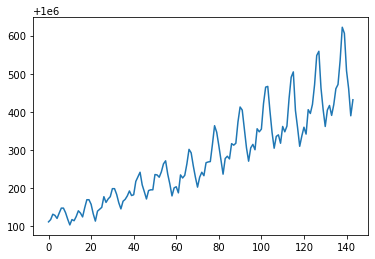

In [631]:
plt.plot(y)

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

This is a multiplicative TSA.

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

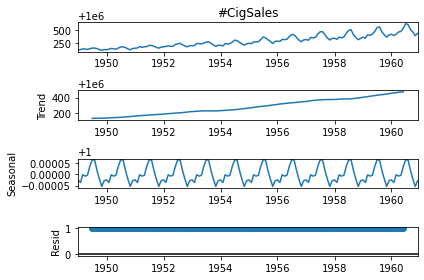

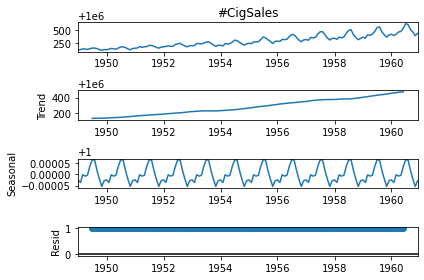

In [632]:
decomposition = sm.tsa.seasonal_decompose(cigData.set_index('Month')['#CigSales'], model='multiplicative')

# Plot the original data, the trend, the seasonality, and the residuals 
decomposition.plot()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [633]:
kpss(cigData.set_index('Month')['#CigSales'], regression='c', nlags='auto', store=False)

(1.651312235417082,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

In [634]:
cigData.head()

,Month,#CigSales
0,1949-01-01,1000112
1,1949-02-01,1000118
2,1949-03-01,1000132
3,1949-04-01,1000129
4,1949-05-01,1000121


In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [635]:
print(np.mean(cigData['#CigSales']))
cigDataLog = pd.DataFrame(cigData)
cigDataLog['#CigSales'] = np.log(cigData['#CigSales']-1000000)
print(cigData['#CigSales'])
print(np.mean(cigData['#CigSales']))
print(np.max(cigData['#CigSales']))
print(np.max(cigDataLog['#CigSales']))

1000280.2986111111
0      1000112
1      1000118
2      1000132
3      1000129
4      1000121
        ...   
139    1000606
140    1000508
141    1000461
142    1000390
143    1000432
Name: #CigSales, Length: 144, dtype: int64
1000280.2986111111
1000622
6.432940092739179



When you plot this, you can see how the variance in our data now remains contant over time.

<AxesSubplot:>

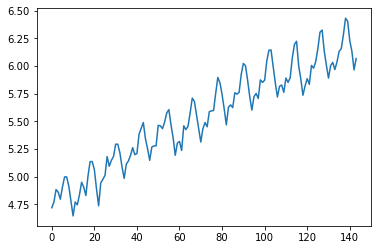

In [636]:
cigDataLog['#CigSales'].plot()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [637]:
cigDataDiff = pd.DataFrame(np.diff(cigDataLog['#CigSales']),index=cigData['Month'][1:len(cigData)],columns=['#CigSales'],)

In [638]:
kpss(cigDataDiff['#CigSales'], regression='c', nlags='auto', store=False)

(0.038304469546740647,
 0.1,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [639]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [640]:
def findMSE(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=round(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in [range(0,len(test))]:
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(test[i])[0]
        predictions.append([future])
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [641]:
def evaluateModels(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = findMSE(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [642]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [643]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluateModels(cigDataLog['#CigSales'], p_values, d_values, q_values)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57029D-01    |proj g|=  3.88578D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      4      1     0     0   1.665D-08   4.570D-01
  F =  0.45702872091355023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.7

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     46     85      1     0     0   4.004D-03  -9.419D-01
  F = -0.94188190644864456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.94424D-01    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -8.47801D-01    |proj g|=  8.70275D-02

At iterate   10    f= -8.47827D-01    |proj g|=  1.62603D+00

At iterate   15    f= -8.47973D-01    |proj g|=  3.11638D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     27      1     0     0   2.985D-04  -8.480D-01
  F = -0.84797337112002402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.19213D-01    |proj g|=  5.48864D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.58314D-01    |proj g|=  6.25757D-02

At iterate    5    f= -8.76483D-01    |proj g|=  1.53522D-04

At iterate   10    f= -8.76484D-01    |proj g|=  3.85025D-05

At iterate   15    f= -8.76484D-01    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     27      1     0     0   4.441D-08  -8.765D-01
  F = -0.87648380385531022     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -8.97814D-01    |proj g|=  9.99201D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     19      1     0     0   9.992D-08  -8.978D-01
  F = -0.89781385932326530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.90620D-01    |proj g|=  1.31079D+00

At iterate    5    f= -9.90663D-01    |proj g|=  2.15437D-01

At iterate   10    f= -9.90690D-01    |proj g|=  1.06584D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -9.90690D-01    |proj g|=  7.12717D-03

At iterate   20    f= -9.90696D-01    |proj g|=  1.02383D-01

At iterate   25    f= -9.90722D-01    |proj g|=  2.17068D-02

At iterate   30    f= -9.90722D-01    |proj g|=  8.99281D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     43      1     0     0   8.993D-07  -9.907D-01
  F = -0.99072216629309207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -8.24975D-01    |proj g|=  4.33435D-01

At iterate   10    f= -8.26452D-01    |proj g|=  5.71938D+00

At iterate   15    f= -8.30205D-01    |proj g|=  1.09624D-01

At iterate   20    f= -8.37302D-01    |proj g|=  1.46782D+00

At iterate   25    f= -8.40511D-01    |proj g|=  2.90928D-01

At iterate   30    f= -8.40594D-01    |proj g|=  9.77089D-02

At iterate   35    f= -8.40599D-01    |proj g|=  5.76815D-03

At iterate   40    f= -8.40599D-01    |proj g|=  4.88114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     41     62      1     0     0   4.881D-03  -8.406D-01
  F = -0.840598968556


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.61475D-01    |proj g|=  1.30668D+01

At iterate    5    f= -8.64688D-01    |proj g|=  5.13245D-02

At iterate   10    f= -8.64705D-01    |proj g|=  9.17543D-01

At iterate   15    f= -8.66350D-01    |proj g|=  8.76536D+00

At iterate   20    f= -8.70500D-01    |proj g|=  1.29190D-02

At iterate   25    f= -8.70512D-01    |proj g|=  9.82573D-01

At iterate   30    f= -8.71118D-01    |proj g|=  3.63118D+00

At iterate   35    f= -8.71255D-01    |proj g|=  9.52801D-03

At iterate   40    f= -8.71256D-01    |proj g|=  1.75115D-01

At iterate   45    f= -8.71389D-01    |proj g|=  2.23211D+00

At iterate   50    f= -8.73189D-01    |proj g|=  2.33299D+00

At iterate   55    f= -8.73454D-01    |proj g|=  1.01712D-01

At iterate   60    f= -8.73678D-01    |proj g|=  9.36945D-01

At iterate   65    f= -8.7


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


At iterate   10    f= -8.50491D-01    |proj g|=  9.99201D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   5.551D-08  -8.505D-01
  F = -0.85049050898292700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.72631D-01    |proj g|=  4.93835D-02

At iterate    5    f= -8.81439D-01    |proj g|=  1.76873D-03

At iterate   10    f= -8.81482D-01    |proj g|=  5.72875D-06

        

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.80839D-01    |proj g|=  9.94127D-02

At iterate    5    f= -8.80892D-01    |proj g|=  7.07536D-03

At iterate   10    f= -8.80893D-01    |proj g|=  6.62470D-04

At iterate   15    f= -8.80893D-01    |proj g|=  5.99520D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   5.440D-07  -8.809D-01
  F = -0.88089278129887771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -9.91756D-01    |proj g|=  7.94807D-01

At iterate   35    f= -9.96814D-01    |proj g|=  7.91210D-01

At iterate   40    f= -9.97773D-01    |proj g|=  1.65612D-02

At iterate   45    f= -9.97803D-01    |proj g|=  1.33855D-02

At iterate   50    f= -9.97805D-01    |proj g|=  1.41459D-02

At iterate   55    f= -9.97805D-01    |proj g|=  3.75645D-03

At iterate   60    f= -9.97805D-01    |proj g|=  1.21325D-04

At iterate   65    f= -9.97805D-01    |proj g|=  1.11244D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     69     94      1     0     0   1.473D-04  -9.978D-01
  F = -0.997804588810

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.80134D-01    |proj g|=  1.23770D+01

At iterate    5    f= -9.87076D-01    |proj g|=  7.60908D-02

At iterate   10    f= -9.87158D-01    |proj g|=  1.27436D+00

At iterate   15    f= -9.88456D-01    |proj g|=  7.01545D-01

At iterate   20    f= -9.88490D-01    |proj g|=  4.60710D-02

At iterate   25    f= -9.88862D-01    |proj g|=  4.74421D-01

At iterate   30    f= -9.89131D-01    |proj g|=  1.54677D-02

At iterate   35    f= -9.89183D-01    |proj g|=  6.07817D-01

At iterate   40    f= -9.90393D-01    |proj g|=  2.15839D+00

At iterate   45    f= -9.90818D-01    |proj g|=  2.12061D-03

At iterate   50    f= -9.90849D-01    |proj g|=  3.35741D-01

At iterate   55    f= -9.91670D-01    |proj g|=  1.67282D+00

At iterate   60    f= -9.92443D-01    |proj g|=  1.01930D-02

At iterate   65    f= -9.9

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.38366D-01    |proj g|=  5.55782D+01

At iterate    5    f= -8.51368D-01    |proj g|=  3.39210D-01

At iterate   10    f= -8.51577D-01    |proj g|=  6.72984D+00

At iterate   15    f= -8.55615D-01    |proj g|=  5.89641D+00

At iterate   20    f= -8.55796D-01    |proj g|=  1.25931D-01

At iterate   25    f= -8.55814D-01    |proj g|=  2.38164D-01

At iterate   30    f= -8.55817D-01    |proj g|=  7.14917D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


Best ARIMANone MSE=inf


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [644]:
p=2
d=1
q=1
model = ARIMA(np.asarray(cigDataLog['#CigSales']), order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.72095D-01    |proj g|=  8.01807D+00

At iterate    5    f= -9.74918D-01    |proj g|=  3.23596D-01

At iterate   10    f= -9.75601D-01    |proj g|=  2.39240D+00

At iterate   15    f= -9.75989D-01    |proj g|=  9.79857D-03

At iterate   20    f= -9.76016D-01    |proj g|=  1.61733D-01

At iterate   25    f= -9.76258D-01    |proj g|=  6.69922D-03

At iterate   30    f= -9.79053D-01    |proj g|=  4.20949D-02

At iterate   35    f= -9.79534D-01    |proj g|=  8.30876D-02

At iterate   40    f= -9.79549D-01    |proj g|=  4.29602D-03

At iterate   45    f= -9.79550D-01    |proj g|=  3.49618D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


We can take a look at a summary of the model this library has built around our data.

In [645]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 140.076
Method:                       css-mle   S.D. of innovations              0.090
Date:                Fri, 19 Aug 2022   AIC                           -270.151
Time:                        13:12:43   BIC                           -255.337
Sample:                             1   HQIC                          -264.131
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.000     23.508      0.000       0.009       0.011
ar.L1.D.y      0.9982      0.076     13.162      0.000       0.850       1.147
ar.L2.D.y     -0.4134      0.077     -5.384      0.000      -0.564      -0.263
ma.L1.D.y     -0.9999      0.028    -35.275      0.000      -1.055      -0.944
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2073           -0.9805j            1.5553           -0.1086
AR.2            1.2073           +0.9805j            1.5553            0.1086
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

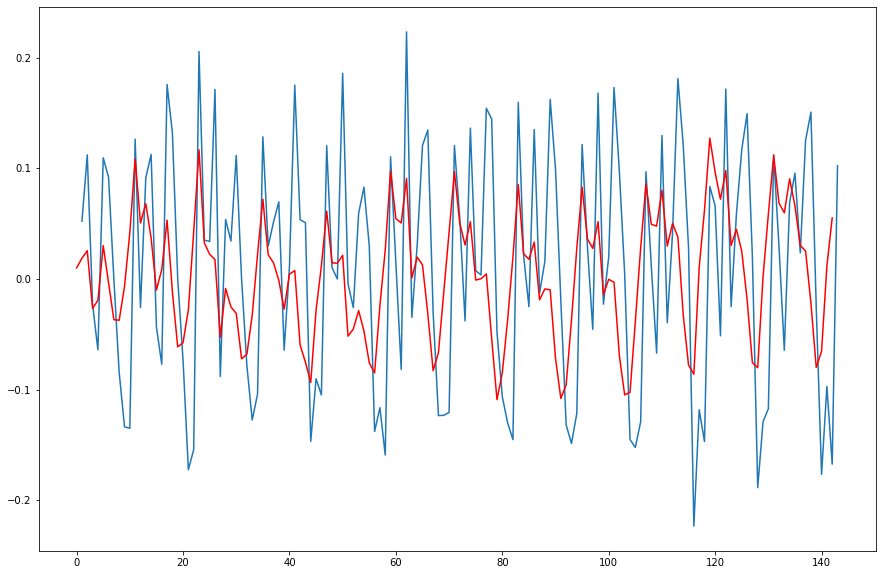

In [646]:
plt.figure(figsize=(15,10))
plt.plot(cigDataLog['#CigSales'].diff())
plt.plot(model_fit.predict(), color = 'red')

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [647]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(cigDataLog.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Month'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
print(type(future_months['Month']))
future_months['Month'] = pd.to_datetime(future_months['Month'])

future_months['Prediction'] = forecast[0]
print(type(cigDataLog['Month']))


cigDataLog['Month'] = pd.to_datetime(cigDataLog['Month'])
print(cigDataLog)
print(future_months)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
         Month  #CigSales
0   1949-01-01   4.718499
1   1949-02-01   4.770685
2   1949-03-01   4.882802
3   1949-04-01   4.859812
4   1949-05-01   4.795791
..         ...        ...
139 1960-08-01   6.406880
140 1960-09-01   6.230481
141 1960-10-01   6.133398
142 1960-11-01   5.966147
143 1960-12-01   6.068426

[144 rows x 2 columns]
        Month  Prediction
0  1970-01-01    6.196734
1  1970-02-01    6.286716
2  1970-03-01    6.327679
3  1970-04-01    6.335553
4  1970-05-01    6.330664
5  1970-06-01    6.326710
6  1970-07-01    6.328969
7  1970-08-01    6.337042
8  1970-09-01    6.348351
9  1970-10-01    6.360485
10 1970-11-01    6.372107
11 1970-12-01    6.382876
12 1971-01-01    6.393004
13 1971-02-01    6.402847
14 1971-03-01    6.412668
15 1971-04-01    6.422587
16 1971-05-01    6.432612
17 1971-06-01    6.442702
18 1971-07-01    6.452813
19 1971-08-01    6.462919
20 1971-09-01    6.473011
21 1971-10-01    6.4

            0
0    4.718499
1    4.770685
2    4.882802
3    4.859812
4    4.795791
5    4.905275
6    4.997212
7    4.997212
8    4.912655
9    4.779123
10   4.644391
11   4.770685
12   4.744932
13   4.836282
14   4.948760
15   4.905275
16   4.828314
17   5.003946
18   5.135798
19   5.135798
20   5.062595
21   4.890349
22   4.736198
23   4.941642
24   4.976734
25   5.010635
26   5.181784
27   5.093750
28   5.147494
29   5.181784
30   5.293305
31   5.293305
32   5.214936
33   5.087596
34   4.983607
35   5.111988
36   5.141664
37   5.192957
38   5.262690
39   5.198497
40   5.209486
41   5.384495
42   5.438079
43   5.488938
44   5.342334
45   5.252273
46   5.147494
47   5.267858
48   5.278115
49   5.278115
50   5.463832
51   5.459586
52   5.433722
53   5.493061
54   5.575949
55   5.605802
56   5.468060
57   5.351858
58   5.192957
59   5.303305
60   5.318120
61   5.236442
62   5.459586
63   5.424950
64   5.455321
65   5.575949
66   5.710427
67   5.680173
68   5.556828
69   5.433722
70   5

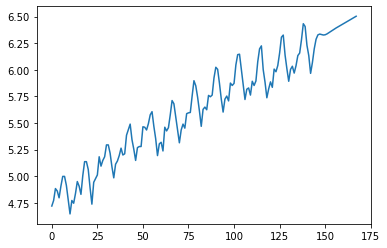

In [682]:
# Plot your future predictions
# Call figure() on plt
future_months['Prediction'] = future_months['Prediction'].astype(float)
cigDataLog['#CigSales'] = cigDataLog['#CigSales'].astype(float)
preds = cigDataLog['#CigSales'].append(pd.Series(future_months['Prediction']))
preds = preds.reset_index()
preds.drop(columns='index', inplace=True) 
print(preds.to_string())
plt.plot(preds)
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 